# Comparing Algorithms: A* vs Dijkstra on the City's Map

In [1]:
import osmnx as ox
import random
import heapq
import csv
import time
import pandas as pd
import matplotlib.pyplot as plt

### Importando y limpiando el mapa

In [2]:
place_name = "Puno, Puno, Perú"
G = ox.graph_from_place(place_name, network_type="drive")
#ox.plot_graph(G)

In [3]:
for edge in G.edges:
    maxspeed = 40
    if "maxspeed" in G.edges[edge]:
        maxspeed = G.edges[edge]["maxspeed"]
        if type(maxspeed) == list:
            speeds = [ int(speed) for speed in maxspeed ]
            maxspeed = min(speeds)
        elif type(maxspeed) == str:
            maxspeed = int(maxspeed)
    G.edges[edge]["maxspeed"] = maxspeed
    # Añadiendo el atributo "weight" (tiempo = distancia / velocidad)
    G.edges[edge]["weight"] = G.edges[edge]["length"] / maxspeed

### Visual 

In [4]:
def estilo_arista_no_visitada(edge):        
    G.edges[edge]["color"] = "#0db48e"
    G.edges[edge]["alpha"] = 0.2
    G.edges[edge]["linewidth"] = 0.5

def estilo_arista_visitada(edge):
    G.edges[edge]["color"] = "#0db48e"
    G.edges[edge]["alpha"] = 1
    G.edges[edge]["linewidth"] = 1

def estilo_arista_activa(edge):
    G.edges[edge]["color"] = '#0dff1c'
    G.edges[edge]["alpha"] = 1
    G.edges[edge]["linewidth"] = 1

def estilo_arista_ruta(edge):
    G.edges[edge]["color"] = "white"
    G.edges[edge]["alpha"] = 1
    G.edges[edge]["linewidth"] = 1

In [5]:
def grafico():
    ox.plot_graph(
        G,
        node_size =  [ G.nodes[node]["size"] for node in G.nodes ],
        edge_color = [ G.edges[edge]["color"] for edge in G.edges ],
        edge_alpha = [ G.edges[edge]["alpha"] for edge in G.edges ],
        edge_linewidth = [ G.edges[edge]["linewidth"] for edge in G.edges ],
        node_color = "white",
        bgcolor = "#18080e"
    )

## Implementacion de los Algoritmos

In [6]:
def dijkstra(orig, dest, plot=False):
    for node in G.nodes:
        G.nodes[node]["visited"] = False
        G.nodes[node]["distance"] = float("inf")
        G.nodes[node]["previous"] = None
        G.nodes[node]["size"] = 0
    for edge in G.edges:
        estilo_arista_no_visitada(edge)
    G.nodes[orig]["distance"] = 0
    G.nodes[orig]["size"] = 50
    G.nodes[dest]["size"] = 50
    pq = [(0, orig)]
    iteraciones = 0
    while pq:
        _, node = heapq.heappop(pq)
        if node == dest:
            if plot:
                print("Iteraciones:", iteraciones)
                grafico()
            return iteraciones
        if G.nodes[node]["visited"]: continue
        G.nodes[node]["visited"] = True
        for edge in G.out_edges(node):
            estilo_arista_visitada((edge[0], edge[1], 0))
            vecino = edge[1]
            weight = G.edges[(edge[0], edge[1], 0)]["weight"]
            if G.nodes[vecino]["distance"] > G.nodes[node]["distance"] + weight:
                G.nodes[vecino]["distance"] = G.nodes[node]["distance"] + weight
                G.nodes[vecino]["previous"] = node
                heapq.heappush(pq, (G.nodes[vecino]["distance"], vecino))
                for edge2 in G.out_edges(vecino):
                    estilo_arista_activa((edge2[0], edge2[1], 0))
        iteraciones += 1
    return iteraciones

In [7]:
def distancia_euclidiana(node1, node2):
    x1, y1 = G.nodes[node1]["x"], G.nodes[node1]["y"]
    x2, y2 = G.nodes[node2]["x"], G.nodes[node2]["y"]
    return ((x2 - x1)**2 + (y2 - y1)**2)**0.5

def a_star(orig, dest, plot=False):
    for node in G.nodes:
        G.nodes[node]["previous"] = None
        G.nodes[node]["size"] = 0
        G.nodes[node]["g_score"] = float("inf")
        G.nodes[node]["f_score"] = float("inf")
    for edge in G.edges:
        estilo_arista_no_visitada(edge)
    G.nodes[orig]["size"] = 50
    G.nodes[dest]["size"] = 50
    G.nodes[orig]["g_score"] = 0
    G.nodes[orig]["f_score"] = distancia_euclidiana(orig, dest)
    pq = [(G.nodes[orig]["f_score"], orig)]
    iteraciones = 0
    while pq:
        _, node = heapq.heappop(pq)
        if node == dest:
            if plot:
                print("Iteraciones:", iteraciones)
                grafico()
            return iteraciones
        for edge in G.out_edges(node):
            estilo_arista_visitada((edge[0], edge[1], 0))
            vecino = edge[1]
            tentative_g_score = G.nodes[node]["g_score"] + distancia_euclidiana(node, vecino)
            if tentative_g_score < G.nodes[vecino]["g_score"]:
                G.nodes[vecino]["previous"] = node
                G.nodes[vecino]["g_score"] = tentative_g_score
                G.nodes[vecino]["f_score"] = tentative_g_score + distancia_euclidiana(vecino, dest)
                heapq.heappush(pq, (G.nodes[vecino]["f_score"], vecino))
                for edge2 in G.out_edges(vecino):
                    estilo_arista_activa((edge2[0], edge2[1], 0))
        iteraciones += 1
    return iteraciones

In [8]:
def reconstruir_ruta(orig, dest, plot=False, algorithm=None):
    for edge in G.edges:
        estilo_arista_no_visitada(edge)
    dist = 0
    speeds = []
    curr = dest
    while curr != orig:
        prev = G.nodes[curr]["previous"]
        dist += G.edges[(prev, curr, 0)]["length"]
        speeds.append(G.edges[(prev, curr, 0)]["maxspeed"])
        estilo_arista_ruta((prev, curr, 0))
        if algorithm:
            G.edges[(prev, curr, 0)][f"{algorithm}_uses"] = G.edges[(prev, curr, 0)].get(f"{algorithm}_uses", 0) + 1
        curr = prev
    dist /= 1000  # Convertir a kilómetros
    avg_speed = sum(speeds) / len(speeds)  # Velocidad promedio en km/h
    tiempo_viaje = (dist / avg_speed) * 60  # Tiempo en minutos

    if plot:
        print(f"Distance: {dist} km")
        print(f"Avg. speed: {avg_speed} km/h")
        print(f"Total time: {tiempo_viaje} min")
        grafico()

    return dist, avg_speed, tiempo_viaje

## Registro de datos


In [10]:
resultados = []

def ejecutar_algoritmos_y_guardar(orig, dest):
    start_time = time.time()
    iteraciones_dijkstra = dijkstra(orig, dest)
    dist_dijkstra, velocidad_promedio_dijkstra, tiempo_dijkstra = reconstruir_ruta(orig, dest)
    tiempo_total_dijkstra = time.time() - start_time

    start_time = time.time()
    iteraciones_a_star = a_star(orig, dest)
    dist_a_star, velocidad_promedio_a_star, tiempo_a_star = reconstruir_ruta(orig, dest)
    tiempo_total_a_star = time.time() - start_time


    resultados.append([
        "dijkstra", iteraciones_dijkstra, dist_dijkstra, velocidad_promedio_dijkstra,
        tiempo_dijkstra, tiempo_total_dijkstra
    ])
    resultados.append([
        "a_star", iteraciones_a_star, dist_a_star, velocidad_promedio_a_star,
        tiempo_a_star, tiempo_total_a_star
    ])

def escribir_resultados_csv(nombre_archivo="resultados.csv"):
    with open(nombre_archivo, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            "Algoritmo", "Iteraciones", "Largo del Camino (km)", 
            "Velocidad Promedio (km/h)", "Tiempo de Viaje (min)", "Tiempo Total (s)"
        ])
        writer.writerows(resultados)
    print(f"Se han guardado {len(resultados)} registros.")
    resultados.clear() 

for _ in range(500):  # Puedes elegir el número de pares que deseas registrar
    orig, dest = random.sample(list(G.nodes), 2)
    ejecutar_algoritmos_y_guardar(orig, dest)

escribir_resultados_csv()

Se han guardado 1000 registros.


## Análisis y Resultados

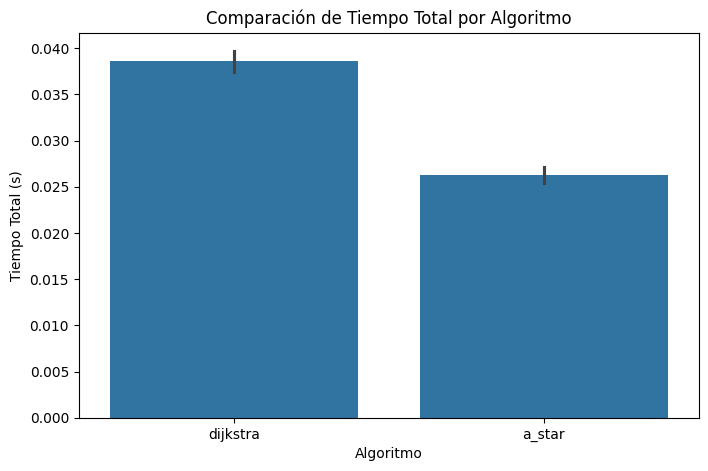

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('resultados.csv')

plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='Algoritmo', y='Tiempo Total (s)')
plt.title('Comparación de Tiempo Total por Algoritmo')
plt.ylabel('Tiempo Total (s)')
plt.show()

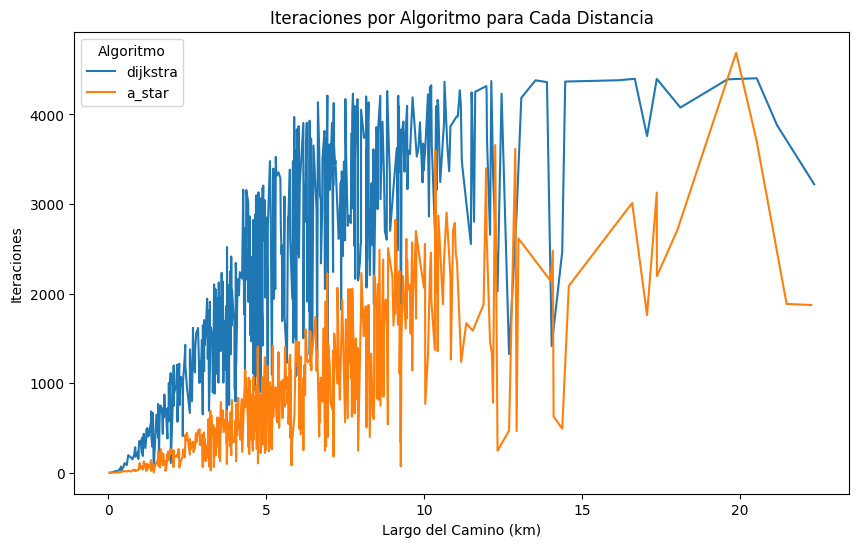

In [12]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Largo del Camino (km)', y='Iteraciones', hue='Algoritmo')
plt.title('Iteraciones por Algoritmo para Cada Distancia')
plt.xlabel('Largo del Camino (km)')
plt.ylabel('Iteraciones')
plt.show()

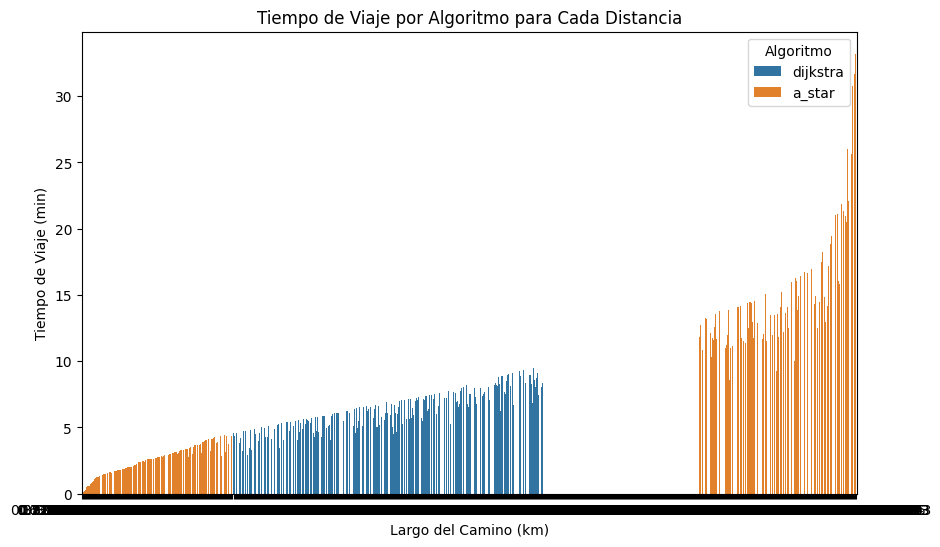

In [13]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Largo del Camino (km)', y='Tiempo de Viaje (min)', hue='Algoritmo')
plt.title('Tiempo de Viaje por Algoritmo para Cada Distancia')
plt.xlabel('Largo del Camino (km)')
plt.ylabel('Tiempo de Viaje (min)')
plt.show()

## Para un par de nodos

In [14]:
start = random.choice(list(G.nodes))
end = random.choice(list(G.nodes))

Iteraciones: 4303


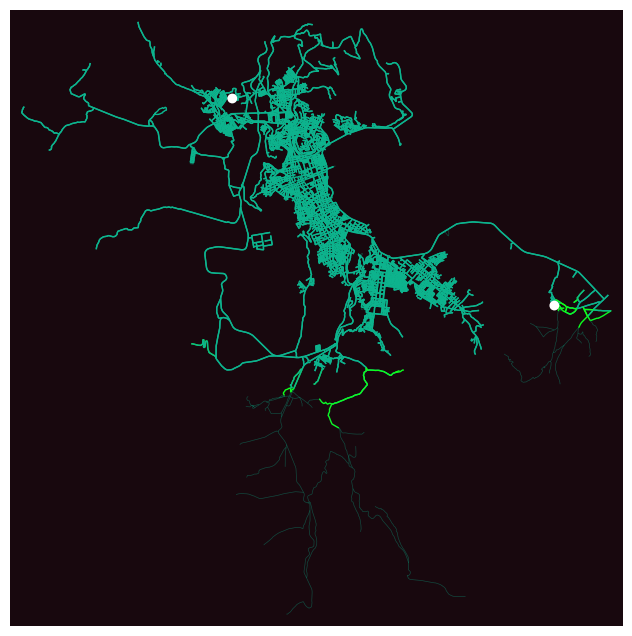

4303

In [15]:
dijkstra(start, end, plot=True)

Distance: 13.186652999999994 km
Avg. speed: 49.50354609929078 km/h
Total time: 15.982676845272199 min


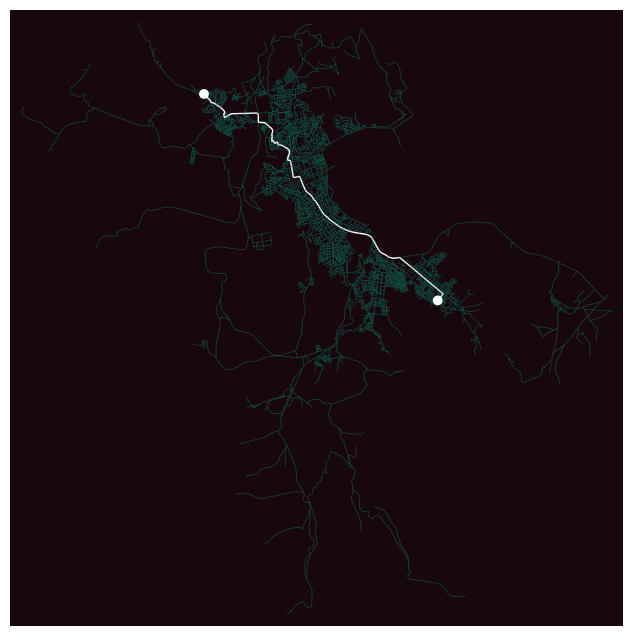

(13.186652999999994, 49.50354609929078, 15.982676845272199)

In [189]:
reconstruir_ruta(start, end, plot=True)

Iteraciones: 2939


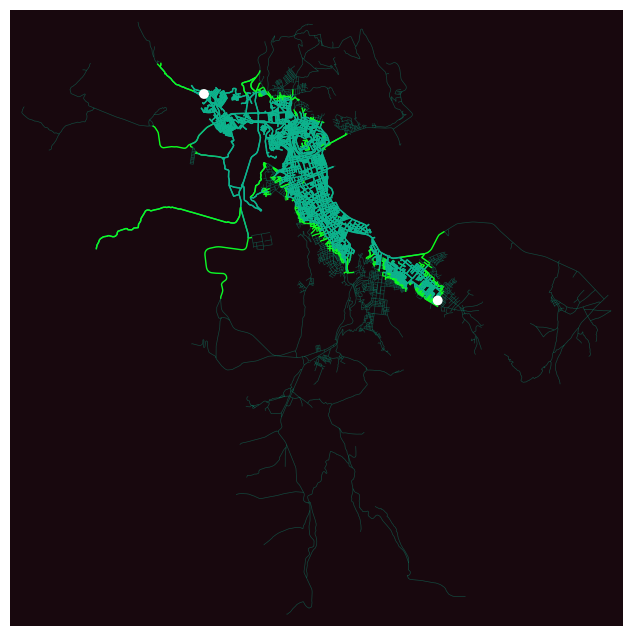

2939

In [190]:
a_star(start, end, plot=True)

Distance: 12.950016999999994 km
Avg. speed: 43.3125 km/h
Total time: 17.939417489177483 min


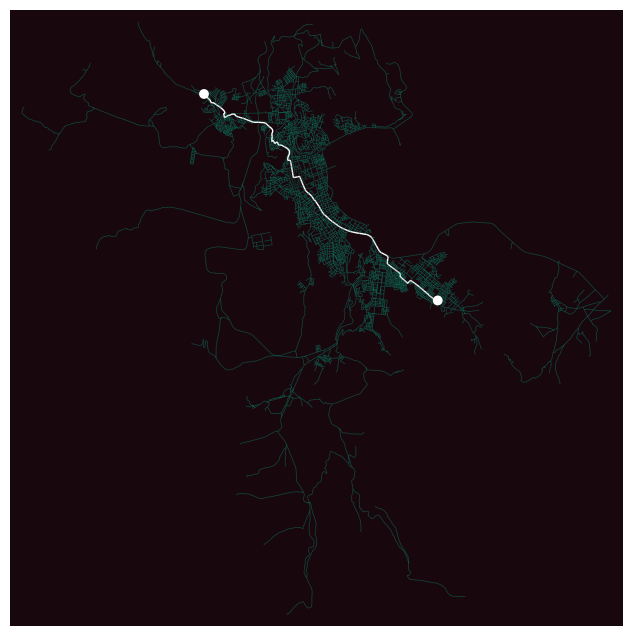

(12.950016999999994, 43.3125, 17.939417489177483)

In [191]:
reconstruir_ruta(start, end, plot=True)